# Embedded ML - Lab 3: Accelerators for ML

Tensor Flow Lite is not only a vehicle to export models to be used in Tensor Flow Lite Micro. It's also an interpreter to run inference on devices that have less resources than servers or standard computers, such as mobile phones, drones, network cameras, etc. In this lab we will use TF Lite to implement an ML application on an embedded platform that features a GPU.

### Learning outcomes


* Explain the differences between a Tensor Flow and a TF Lite environment
* Use the TF Lite API to implement an ML application on an embedded GPU
* Understand the performance differences between TF and TF Lite
* Understand the performance differences between embedded and higher-end GPUs
* Use tools for execution time and memory measurement

### Basic performance measurement

In this lab you'll be required to measure the execution **time** and **memory** consumption of certain code sequences. There are many ways of achieving this and you are encouraged to investigate yourself a bit what options are available and how they differ from each other.

When measuring **execution time**, you should think and decide what is the piece of code you are really interested in measuring, and your conclusions must take that into account. Also notice that the shorter time the code takes, the less accurate can be the measurement because any other thing happening in the system will be a significant noise. Besides using more specialized libraries for accurate time measuring, one common trick you can use is to run a short piece of code many times in a loop, measuring the total loop time and diving by the number of iterations. For this lab you could start with the **time.time()** method of the time Python library.

In [ ]:
import time

start = time.time()

# here goes the code you want to measure

end = time.time()
print("Execution time:", end - start, "seconds")

Execution time: 3.457069396972656e-05 seconds


With respect to memory consumption, different parts of a program require different amounts of memory. In this lab we are instrested in the maximum amount of memory, or **peak memory**, because it determines an absolute resource requirement that any device that aims to run the code must meet.

For this lab you could start with the **memory_info()** method of psutil Python library.

# Review Devices

In [ ]:
import psutil, os

process = psutil.Process(os.getpid())
before = process.memory_info().rss

# here goes the code you want to measure

after = process.memory_info().rss
print(f"Memory increased by {(after - before) / 1024 / 1024:.2f} MB")

Memory increased by 0.00 MB


In [ ]:
import tensorflow as tf
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Disable all GPUs
#tf.config.set_visible_devices([], 'GPU')

# Enable GPU
tf.config.set_visible_devices(gpus[0], 'GPU')

visible_devices = tf.config.get_visible_devices()
print(visible_devices)

### TensorFlow Lite workflow

We have already seen the TF Lite basic workflow in Lab 2.2. We will now use TF Lite on an embedded platform that includes a GPU device to understand its capabilities and limitations.

Run the following code on the **Jetson Nano board** and on a **workstation GPU** and compare their **latencies** amd **peak memory** usage. The code **trains** and exports a TF Lite model for classifying the Fashion MNIST dataset.

# 1. FMNIST


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import json
import tracemalloc
import psutil
import time
import os

In [ ]:
archivo = "stats.json"

if os.path.exists(archivo):
    with open(archivo, 'r') as f:
        data = json.load(f)
else:
    datos = data = {"exp1": {}}

exp = "exp1"
device = "Workstation"  # or "JetsonNano"
gpu = "NO_GPU"


In [ ]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Función para leer imágenes Fashion MNIST en formato IDX
def load_fashion_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        return images

# Función para leer labels Fashion MNIST en formato IDX
def load_fashion_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Base path to the Fashion MNIST dataset after downloading with kagglehub
dataset_base_path = "/kaggle/input/fashionmnist"

# Cargar imágenes y labels de Fashion MNIST
train_images_path = os.path.join(dataset_base_path, "train-images-idx3-ubyte")
train_labels_path = os.path.join(dataset_base_path, "train-labels-idx1-ubyte")
test_images_path = os.path.join(dataset_base_path, "t10k-images-idx3-ubyte")
test_labels_path = os.path.join(dataset_base_path, "t10k-labels-idx1-ubyte")


train_images = load_fashion_mnist_images(train_images_path)
train_labels = load_fashion_mnist_labels(train_labels_path)
test_images = load_fashion_mnist_images(test_images_path)
test_labels = load_fashion_mnist_labels(test_labels_path)

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Class names for the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 1.1 Measure with TF

### Train

In [ ]:
process = psutil.Process(os.getpid())
before = process.memory_info().rss
start = time.time()

model.fit(train_images, train_labels, epochs=2)

end = time.time()
after = process.memory_info().rss
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

data[exp]["time_train_TF"] = end - start
data[exp]["mem_train_TF"] = mem
data[exp]["config"] = {
	"device": device,
	"gpu": gpu,
}

print(f"\nTime: {(end - start):2f}[s], Memory {mem:.2f} MB")
print('\nFinished model training')

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8774 - loss: 0.3403
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8833 - loss: 0.3124

Time: 9.468764[s], Memory 2.13 MB

Finished model training


### Train (Only Python)

In [ ]:
# Medición de memoria con tracemalloc (solo memoria Python)
tracemalloc.start()
before_psutil = process.memory_info().rss

start = time.perf_counter()

model.fit(train_images, train_labels, epochs=2)

end = time.perf_counter()

after_psutil = process.memory_info().rss
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

mem_tracemalloc = peak / 1024 / 1024  # MB

print(f"Time: {(end - start):2f}[s], Memory peak {mem_tracemalloc:.2f} MB")

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8927 - loss: 0.2912
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8980 - loss: 0.2788
Time: 19.451507[s], Memory peak 359.09 MB


### Test

In [ ]:
process = psutil.Process(os.getpid())
before = process.memory_info().rss

start = time.time()
# test model accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

end = time.perf_counter()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

data[exp]["time_total_infer_TF"] = end - start
data[exp]["time_avg_infer_TF"] = (end - start)/test_images.shape[0]
data[exp]["mem_infer_TF"] = mem
print(f"Time: {(end - start):2f}[s], avg time: {((end-start)/test_images.shape[0]):2f}[s], \
Memory {mem:.2f} MB")

# export model to a keras file
model.save("fmnist.keras")

313/313 - 1s - 5ms/step - accuracy: 0.8787 - loss: 0.3329

Test accuracy: 0.8787000179290771
Time: -1752610538.662941[s], avg time: -175261.053866[s], Memory 39.91 MB


### Test (Measure Only Python Memory)

In [ ]:
# Medición de memoria con tracemalloc (solo memoria Python)
tracemalloc.start()
before_psutil = process.memory_info().rss

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

after_psutil = process.memory_info().rss
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

mem_tracemalloc = peak / 1024 / 1024  # MB

print(f"Memory peak {mem_tracemalloc:.2f} MB")

313/313 - 2s - 6ms/step - accuracy: 0.8747 - loss: 0.3468
Memory peak 59.96 MB


Verify that the model files were exported and use them to run **inference**, both on the Jetson Nano and on a **workstation GPU** using **Tensor Flow**. Contrast **latency** and **peak memory** results too.

### Review Accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


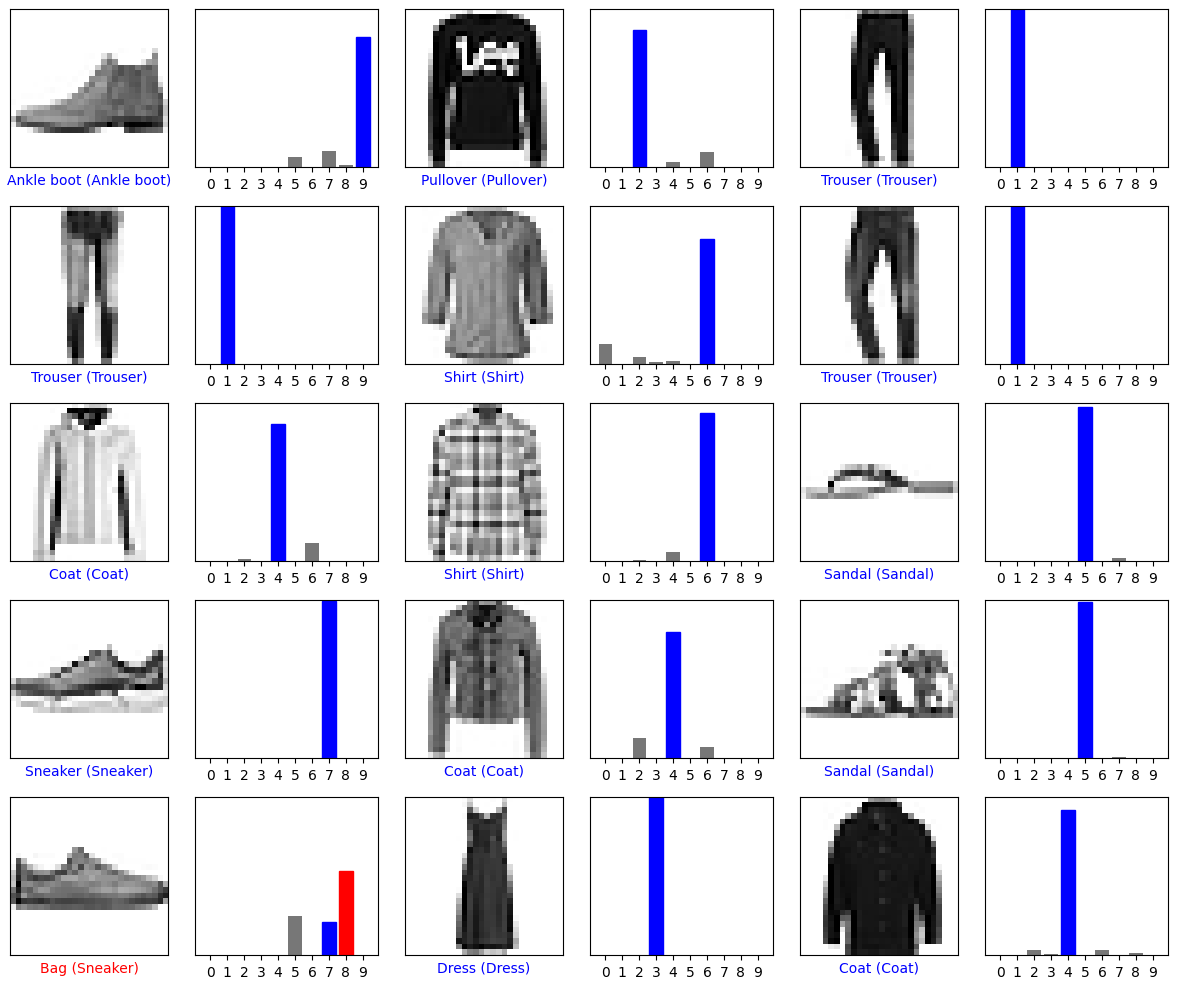

In [ ]:
predictions = model.predict(test_images)

# Function to plot the image, its true label, and the predicted label
def plot_image(i, predictions_array, true_label, img):
	true_label, img = true_label[i], img[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])

	plt.imshow(img, cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)
	if predicted_label == true_label:
		color = 'blue'
	else:
		color = 'red'

	plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
	true_label = true_label[i]
	plt.grid(False)
	plt.xticks(range(10))
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#777777")
	plt.ylim([0, 1])
	predicted_label = np.argmax(predictions_array)

	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
	plot_image(i, predictions[i], test_labels, test_images)
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
	plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### 1.2. FMNIST on TensorFlow Lite

Finally, run **inference** with **TF Lite** on both platforms and compare with the previous execution's **latency** and **peak memory** usage.

In [ ]:
# load model from a keras file
from keras.models import load_model

model = load_model("fmnist.keras")

In [ ]:
# convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save converted model to a file
import pathlib
tflite_model_file = pathlib.Path('fmnist.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmppa524cw0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140567807432016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565123655504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565123656464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140565123651472: TensorSpec(shape=(), dtype=tf.resource, name=None)


409012

## fmnist tflite (

In [ ]:
import numpy as np
import tensorflow as tf
import struct
import time, tracemalloc, os ,psutil

jetson_nano_power = 10  # Watts

# Función para leer imágenes MNIST en formato IDX
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows, cols)
        return images

# Función para leer labels MNIST en formato IDX
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Cargar imágenes y labels
# test_images = load_mnist_images("mnist_dataset/t10k-images.idx3-ubyte")
# test_labels = load_mnist_labels("mnist_dataset/t10k-labels.idx1-ubyte")

# Load the Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Selecciona el índice de la imagen a usar
idx = 1
img = test_images[idx]
real_label = test_labels[idx]

# Normalizar y dar forma para TFLite
input_image = img.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)      # (1, 28, 28)

print("Input shape for TFLite:", input_image.shape)
print("Real label:", real_label)

# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter(model_path="fmnist.tflite")
interpreter.allocate_tensors()

# Obtener detalles de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ajustar tipo de dato si es necesario
input_image = input_image.astype(input_details[0]['dtype'])

# Pasar la imagen al modelo
interpreter.set_tensor(input_details[0]['index'], input_image)

# Medición de memoria con tracemalloc (solo memoria Python)
tracemalloc.start()
process = psutil.Process(os.getpid())
before_psutil = process.memory_info().rss

start = time.perf_counter()
interpreter.invoke()
end = time.perf_counter()

after_psutil = process.memory_info().rss
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

mem_tracemalloc = peak / 1024 / 1024  # MB

print(f"Time: {(end - start):2f}[s], Memory peak {mem_tracemalloc:.2f} MB")

# Obtener la salida
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print("Output:", output_data)
print("Predicted class:", predicted_class)

inference_time_tflite = end - start

estimated_energy_joules = inference_time_tflite * jetson_nano_power
estimated_energy_watt_hours = estimated_energy_joules / 3600  # Convert Joules to Watt-hours

print(f"Estimated Energy Consumption (Workstation GPU): {estimated_energy_joules:.4f} Joules ({estimated_energy_watt_hours:.6f} Wh)")

# CNNs on Tensor Flow Lite

Now it's your turn to develop a TF Lite application. This time make sure you train a convolutional model to classify images from a different dataset you choose from Kaggle, Roboflow, Hugging Face or similar, not Mnist, Fashion Mnist nor ImageNet. Now, performance evaluation will focus only on **inference**.

Use the Jetson Board and the workstation to run inference both with Tensor Flow and TF Lite. Measure the **peak memory** and **time** and estimate the **energy** consumed based on the nominal power consumption of each system or chip.

Repeat the experiments without using a GPU and compare the results. Use the following code to disable GPU use in TensorFlow.

Again, consolidate all results in one or more tables or plots and write down your conclusions.

## 2.1. CNN TensorFlow

In [ ]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Disable all GPUs
#tf.config.set_visible_devices([], 'GPU')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print("Memory growth setup failed:", e)

❌ Memory growth setup failed: Physical devices cannot be modified after being initialized


### Load and Download CNN Dataset (Only Colab!)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

100%|██████████| 306M/306M [00:04<00:00, 78.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


In [ ]:
# mueve el dataset a la carpeta /content

!mv /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/* /content/

In [ ]:
# prompt: download a folder a zip file from the folder /content/

import shutil

# Zip the desired folder
shutil.make_archive("dataset", "zip", "/content/versions/")

# Download the zip file
from google.colab import files
files.download("dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load and Overview CNN Dataset

In [ ]:
import numpy as np
import os
import shutil

# Define the base directory where the dataset is located
base_dir = '/content/versions/2'

# Define the directories for the original data
paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')

# Define the directories for the training and testing data
train_dir = os.path.join(base_dir, 'rps_train')
test_dir = os.path.join(base_dir, 'rps_test')

train_paper_dir = os.path.join(train_dir, 'paper')
train_rock_dir = os.path.join(train_dir, 'rock')
train_scissors_dir = os.path.join(train_dir, 'scissors')

test_paper_dir = os.path.join(test_dir, 'paper')
test_rock_dir = os.path.join(test_dir, 'rock')
test_scissors_dir = os.path.join(test_dir, 'scissors')

# Create the training and testing directories
os.makedirs(train_paper_dir, exist_ok=True)
os.makedirs(train_rock_dir, exist_ok=True)
os.makedirs(train_scissors_dir, exist_ok=True)

os.makedirs(test_paper_dir, exist_ok=True)
os.makedirs(test_rock_dir, exist_ok=True)
os.makedirs(test_scissors_dir, exist_ok=True)

# Function to split data
def split_data(source_dir, train_dir, test_dir, split_size):
    files = os.listdir(source_dir)
    # Filter out non-image files if necessary (e.g., .DS_Store)
    files = [f for f in files if os.path.isfile(os.path.join(source_dir, f))]
    # Shuffle the files to ensure random splitting
    np.random.shuffle(files)

    split_index = int(len(files) * split_size)
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Copy files to the training directory
    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), train_dir)

    # Copy files to the testing directory
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), test_dir)

# Define the split ratio (e.g., 80% for training, 20% for testing)
split_size = 0.8

# Split the data for each class
split_data(paper_dir, train_paper_dir, test_paper_dir, split_size)
split_data(rock_dir, train_rock_dir, test_rock_dir, split_size)
split_data(scissors_dir, train_scissors_dir, test_scissors_dir, split_size)

print(f"Splitting complete. Data moved to {train_dir} and {test_dir}")
print(f"Number of training paper images: {len(os.listdir(train_paper_dir))}")
print(f"Number of testing paper images: {len(os.listdir(test_paper_dir))}")
print(f"Number of training rock images: {len(os.listdir(train_rock_dir))}")
print(f"Number of testing rock images: {len(os.listdir(test_rock_dir))}")
print(f"Number of training scissors images: {len(os.listdir(train_scissors_dir))}")
print(f"Number of testing scissors images: {len(os.listdir(test_scissors_dir))}")


Splitting complete. Data moved to /content/versions/2/rps_train and /content/versions/2/rps_test
Number of training paper images: 569
Number of testing paper images: 143
Number of training rock images: 580
Number of testing rock images: 146
Number of training scissors images: 600
Number of testing scissors images: 150


### Preprocess CNN Dataset

In [ ]:
import tensorflow as tf

batch_size = 32
img_height = 150
img_width = 150
# Use ´test_ds = tf.keras.preprocessing.image_dataset_from_directory' in TF 2.4
# TODO: Change utils by 'preprocessing' if TF = 2.4
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1749 files belonging to 3 classes.
Found 439 files belonging to 3 classes.
['paper', 'rock', 'scissors']


### Train CNN Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# create model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
history = model.fit(
    train_ds,
    epochs=5
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.4927 - loss: 189.1671
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8823 - loss: 0.3639
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9572 - loss: 0.1355
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9362 - loss: 0.2090
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9578 - loss: 0.1290
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9697 - loss: 0.0801
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9874 - loss: 0.0280
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9949 - loss: 0.0109
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9989 - loss: 0.0076
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9990 - loss: 0.0050


### Test

In [ ]:
# evalute model
process = psutil.Process(os.getpid())
before = process.memory_info().rss
start = time.time()

test_loss, test_acc = model.evaluate(test_ds)

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

print('Test accuracy:', test_acc)
print(f"\nTime: {(end - start):2f}[s], Memory {mem:.2f} MB")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9821 - loss: 0.0865
Test accuracy: 0.9772209525108337


### Test (Only Python)

In [ ]:
# evalute model
tracemalloc.start()
before_psutil = process.memory_info().rss

start = time.perf_counter()

test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

end = time.perf_counter()

after_psutil = process.memory_info().rss
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

mem_tracemalloc = peak / 1024 / 1024  # MB

print(f"Time: {(end - start):2f}[s], Memory peak {mem_tracemalloc:.2f} MB")

In [ ]:
# load model
from keras.models import load_model

model = load_model("rps.keras")

## 2.2. CNN TensorFlow Lite

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import time
import psutil, os

jetson_nano_power = 10  # Watts
# Load your test image (replace 'path/to/your/test_image.jpg' with the actual path)
#image_path = 'dataset/rps_test/paper/4IwJ2iL6pFz5ARWA.png' # Example path, change as needed
#image_path = 'dataset/rps_test/rock/1BqjHe5igJAgUjiN.png' # Example path, change as needed
image_path = 'dataset/rps_test/scissors/0CSaM2vL2cWX6Cay.png' # Example path, change as needed
img = Image.open(image_path).convert('RGB') # Ensure image is in RGB format

img = img.resize((150, 150))
input_image = np.array(img, dtype=np.float32)
input_image = np.expand_dims(input_image, axis=0) # Add batch dimension
tflite_model_file = "rps"
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_file+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

start = time.time()
process = psutil.Process(os.getpid())
before = process.memory_info().rss

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

end = time.time()
after = process.memory_info().rss
mem = (after - before) / 1024 / 1024

print(f"Time: {(end - start):2f}[s], Memory {mem:.2f} MB")

# Print the output
print("Output:", output_data)

# Optionally, you can get the predicted class
predicted_class_index = np.argmax(output_data)

# class names to interpret the result
class_names = ['paper', 'rock', 'scissors'] # Replace with your actual class names
predicted_class_name = class_names[predicted_class_index]
print("Predicted class:", predicted_class_name)


inference_time_tflite = end - start

estimated_energy_joules = inference_time_tflite * jetson_nano_power
estimated_energy_watt_hours = estimated_energy_joules / 3600  # Convert Joules to Watt-hours

print(f"Estimated Energy Consumption (jetson GPU): {estimated_energy_joules:.4f} Joules ({estimated_energy_watt_hours:.6f} Wh)")

XLA (Álgebra Lineal Acelerada) is the open source compiler used to optimize the opperations used in the GPU. According to a simple tensorflow import in the jetson, we noticed that the GPU was recognized, but the XLA devices were not set. It means that it won't optimize the operations.

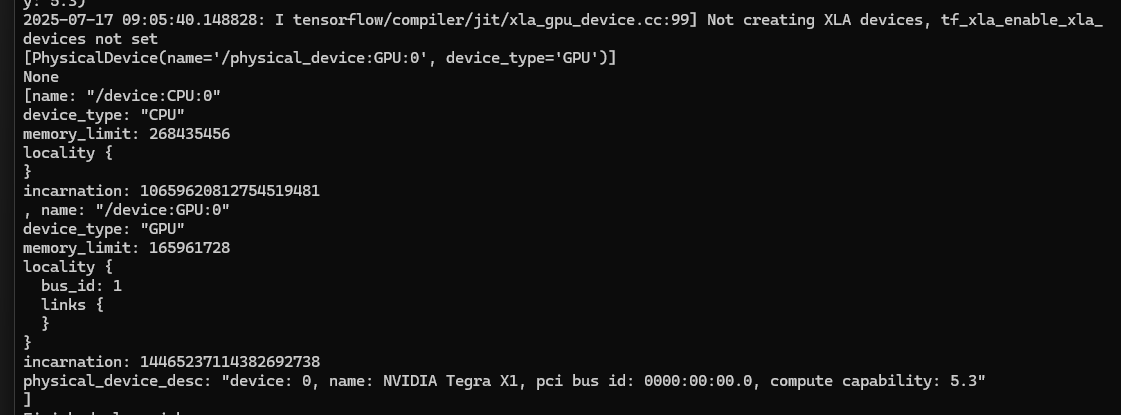

# Results

FMNIST:




| Metric   | JetsonNano TF | JetsonNano TF Lite | Workstation TF | Workstation TF Lite |
|----------|---------------|---------------------|----------------|----------------------|
| Time Train    | x | x | |  x |
| Time Train GPU   |x |x  | 10.45   |  x   |
| Time Test    |1.621518| 0.000217 | 0.494   |   0.000145    |
| Time Test GPU   |  7.887850  | 0.000223|  0.403582 | 0.000158|
| Memory Train  |  x |   x |  |          x            |
| Memory Train GPU   | x |x  | 382.70  |   x    |
| Memory Test  | 39.67  | 0.05   | 29.54    | 0.01|
| Memory Test GPU   | 0.000789 | 0.000223  |  0.000040 |   0.01    |

**Table 1. Measurements in fmnist**


CNN Rock Scissor Paper [Time, Peak Memory, Energy]:




| Metric   | JetsonNano TF | JetsonNano TF Lite | Workstation TF | Workstation TF Lite |
|----------|---------------|---------------------|----------------|----------------------|
| Time     | 209.588    | 0.0929|   3.59144    | 0.027424                     |
| Memory   | 1.17  |81.18  |  0.09    |    72.50      |
| Energy   | 0.5821  |0.000258  | 0.02494   |   0.001905     |
| Time GPU    | 70.56 (0.106) |0.581855 |  26.311746  | 0.03422     |
| Memory GPU | 1.23  | 80.54  | 2.16  |   82.25   |
| Energy GPU |  0.1959  | 0.002039  |0.001905                |0.002039       |

**Table 2. Measurements in devices with GPU**